In [1]:
import numpy as np
import pandas as pd
import sys
#from utils import score
sys.path.pop(0)
from RealData.EpsGreedy import epsilon_greedy_policy, run_epsilon_policy
from RealData.LoadData import create_dataframe
""" 
from RealData. import 
from RealData. import 
from RealData. import 
from RealData. import 
from RealData. import 
#from RealData. import 
"""
import matplotlib.pyplot as plt
import argparse
np.random.seed(2025)

# Load the Data

In [2]:
df = create_dataframe()

reading movielens 20m data
preparing ratings log


In [3]:
df.head()

,userId,movieId,rating,timestamp,movieId_movie,title,(no genres listed),Action,Adventure,Animation,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,t,liked
t,,,,,,,,,,,,,,,,,,,,,
0,13514,208,3.5,1433992410,210.0,Wild Bill (1995),False,False,False,False,...,False,False,False,False,False,False,False,True,0,0
1,92129,288,4.5,1377708053,292.0,Outbreak (1995),False,True,False,False,...,False,False,False,False,True,True,False,False,1,1
2,141625,1682,3.5,1378451121,1753.0,Half Baked (1998),False,False,False,False,...,False,False,False,False,False,False,False,False,2,0
3,100871,6539,4.0,1111574259,6662.0,"Pink Panther, The (1963)",False,False,False,False,...,False,False,False,False,False,False,False,False,3,0
4,55201,7361,4.5,1149041890,7573.0,Never Say Never Again (1983),False,True,True,False,...,False,False,False,False,False,True,False,False,4,1


# Run experiments

## EpsilonGreedy Policy

### Fixed $ \epsilon $

#### Experience 1

/Users/augustincablant/Documents/GitHub/Advanced-ML/src/RealData/EpsGreedy.py:178: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, actions])


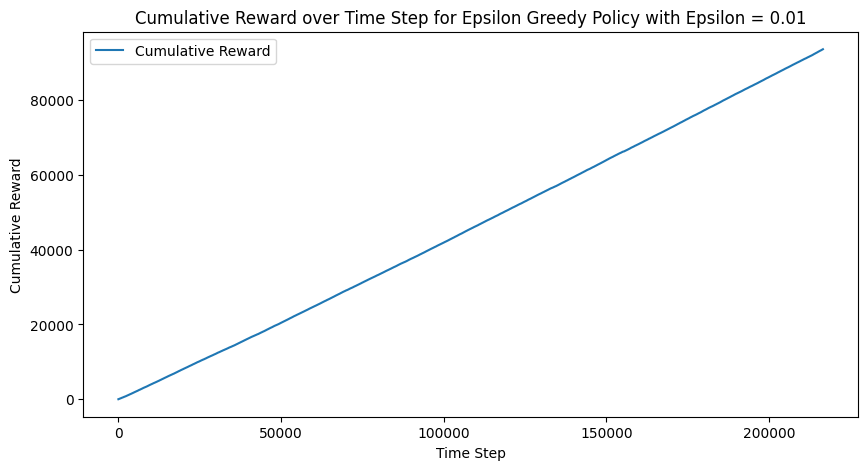

In [4]:
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})
rewards, history = run_epsilon_policy(df, history, epsilon = .01, slate_size = 5, batch_size = 10000, verbose = False, plot = True)

#### Experience 2

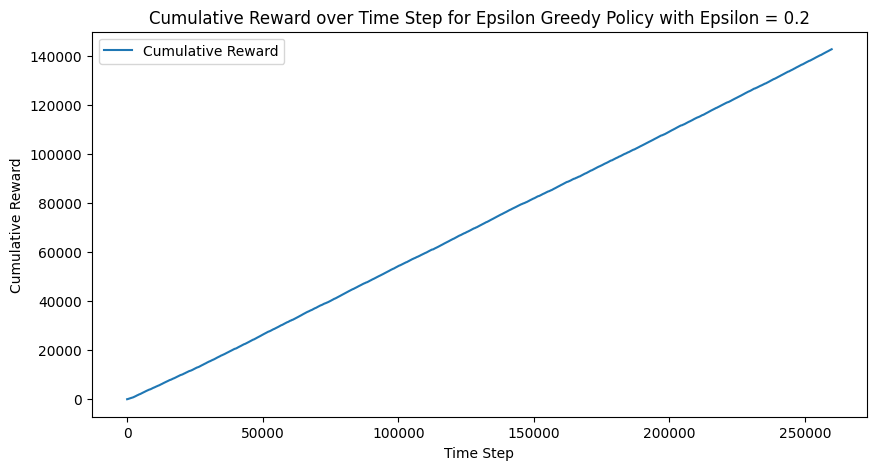

In [5]:
history2 = pd.DataFrame(data=None, columns=df.columns)
history2 = history.astype({'movieId': 'int32', 'liked': 'float'})
rewards2, history2 = run_epsilon_policy(df, history, epsilon = .2, slate_size = 5, batch_size = 10000, verbose = False, plot = True)

#### Experience 3

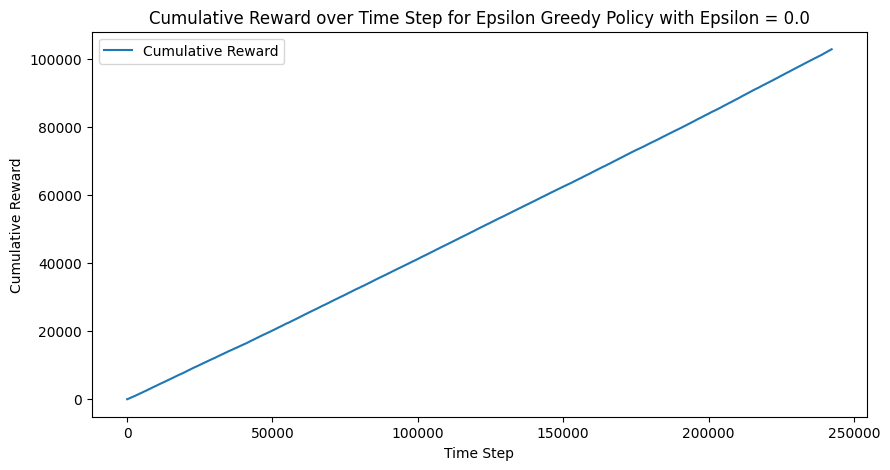

In [6]:
history3 = pd.DataFrame(data=None, columns=df.columns)
history3 = history.astype({'movieId': 'int32', 'liked': 'float'})
rewards3, history3 = run_epsilon_policy(df, history, epsilon = .5, slate_size = 5, batch_size = 10000, verbose = False, plot = True, fixed_epsilon=False)

#### Comparison

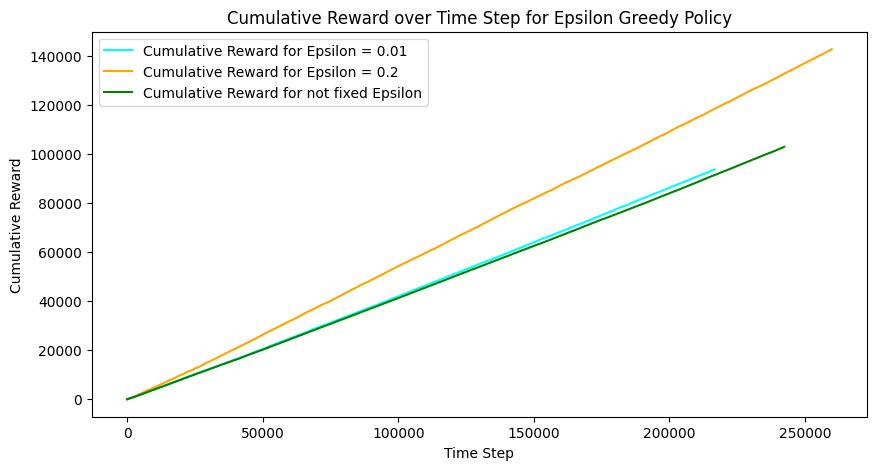

In [7]:
plt.figure(figsize = (10, 5))
plt.plot(np.cumsum(rewards), label = 'Cumulative Reward for Epsilon = 0.01', color = 'cyan')
plt.plot(np.cumsum(rewards2), label = 'Cumulative Reward for Epsilon = 0.2', color = 'orange')
plt.plot(np.cumsum(rewards3), label = 'Cumulative Reward for not fixed Epsilon', color = 'green')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time Step for Epsilon Greedy Policy')
plt.legend()
plt.show()